Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/' #download link
last_percent_reported = None #to show loading progress
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
##########################################
# --- example solution for Problem 1 --- #
##########################################

# list some image file names
print('dirs', os.listdir('notMNIST_large'))
print('files', os.listdir('notMNIST_large/A')[0:10])

# diplay one of the files from above list
file_name = "notMNIST_large/A/ZWFydGhsaW5nLi50dGY=.png"
Image(filename=file_name)

dirs ['H', 'A.pickle', 'C.pickle', 'G.pickle', 'E', 'I', 'J', 'D.pickle', 'I.pickle', 'B.pickle', 'J.pickle', 'B', 'D', 'G', 'A', 'H.pickle', 'F.pickle', 'C', 'F', 'E.pickle']
files ['Um9zZU5vdGUudHRm.png', 'QmlnIENodW1wIEJUTiBDb25kIE91dC50dGY=.png', 'Qmxhbmtib3hlci1JdGFsaWMudHRm.png', 'R3JpZGRlci1PRkYub3Rm.png', 'U3RvbmVTYW5zT1NJVEMtTWVkaXVtLm90Zg==.png', 'TFRVbml2ZXJzLUNvbmRCbGFja0l0YWxpYy5vdGY=.png', 'SGlnaGxhbmRlciBNZCBJVEMgVFQgTWVkaXVtLnR0Zg==.png', 'QXJpYWwtSXRhbGljTVQub3Rm.png', 'SGV5IEtpZHMhLnR0Zg==.png', 'UmVndWxhdG9yLVRoaW5JdGFsaWMub3Rm.png']


---

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [5]:
image_size = 28  # Pixel width and height. (NxN images assumed)
pixel_depth = 255.0  # Number of levels per pixel. 

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder) #list all image files
  #Init numpy array to store images as arrays of intensity values (White-Black range): https://imageio.readthedocs.io/en/stable/_autosummary/imageio.imread.html?highlight=imread
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32) 
  print(folder)
  num_images = 0 #Initialize to count images
  for image in image_files:
    image_file = os.path.join(folder, image) #Get full path to image file
    try:
      #Read image into numpy array, normalizing the values to 255.0 base level & standardizing to a (-1;1) interval
      ### Intensity > 255.0/2 -> [i - 255/2] > 0 ; Intensity < 255.0/2 -> [i - 255/2] <0 ; else 0 ; division is used to stdize to -1 to 1 interval
      image_data = (imageio.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth 
      
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape)) #particular case - images are expected to be of the same specific size
      dataset[num_images, :, :] = image_data #Add current image data to the numpy array
      num_images = num_images + 1 #increment image number
    except (IOError, ValueError) as e: #failsafe if image is of the wrong format
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :] #Resize numpy array to the actual number of added images
  if num_images < min_num_images: #In case something is wrong with the data format
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  '''Used to save nparray-formatted datasets for future use'''
  dataset_names = [] #To store file names
  for folder in data_folders:
    set_filename = folder + '.pickle' #File name derived from dataset folder name (related letter)
    dataset_names.append(set_filename) #Save file name
    if os.path.exists(set_filename) and not force: #If not already saved or resaving is forced
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class) #Generate dataset from images
      try:
        with open(set_filename, 'wb') as f: #Save dataset to a file
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e: #If dataset is not saveable
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names #

train_datasets = maybe_pickle(train_folders, 45000) #Pre-process training data
test_datasets = maybe_pickle(test_folders, 1800) #Pre-process test data

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

dataset: ./notMNIST_large/A.pickle
dataset shape: (52909, 28, 28)
sample image:


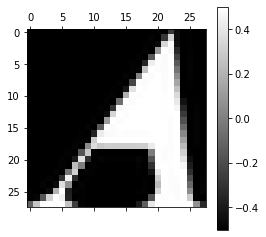

dataset: ./notMNIST_large/B.pickle
dataset shape: (52911, 28, 28)
sample image:


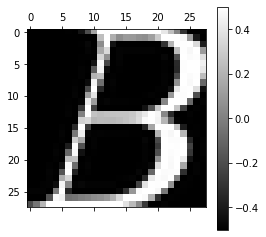

dataset: ./notMNIST_large/C.pickle
dataset shape: (52912, 28, 28)
sample image:


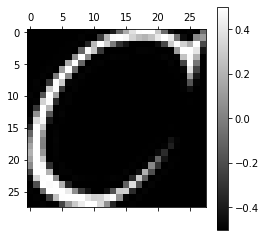

dataset: ./notMNIST_large/D.pickle
dataset shape: (52911, 28, 28)
sample image:


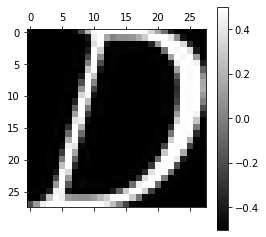

dataset: ./notMNIST_large/E.pickle
dataset shape: (52912, 28, 28)
sample image:


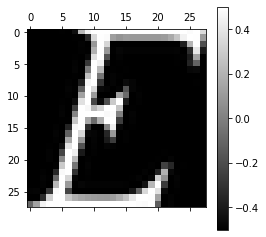

dataset: ./notMNIST_large/F.pickle
dataset shape: (52912, 28, 28)
sample image:


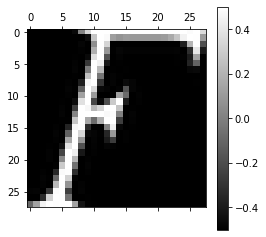

dataset: ./notMNIST_large/G.pickle
dataset shape: (52912, 28, 28)
sample image:


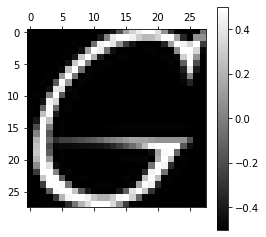

dataset: ./notMNIST_large/H.pickle
dataset shape: (52912, 28, 28)
sample image:


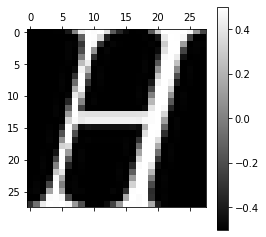

dataset: ./notMNIST_large/I.pickle
dataset shape: (52912, 28, 28)
sample image:


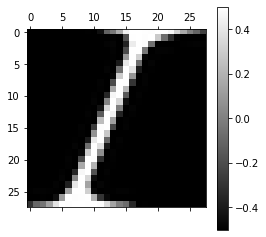

dataset: ./notMNIST_large/J.pickle
dataset shape: (52911, 28, 28)
sample image:


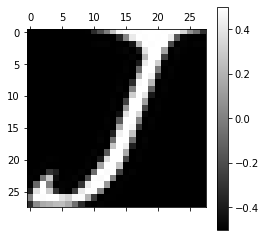

In [6]:
##########################################
# --- example solution for Problem 2 --- #
##########################################

for data_set_name in train_datasets: 
    print('dataset:', data_set_name) 
    with open(data_set_name, 'rb') as f:
        data_set = pickle.load(f) #Load pickled dataset to memory
    
    print('dataset shape:', data_set.shape) #Number of images, width, height
    
    print('sample image:')
    # HINT, try data_set[2] to see that not all letters are recognizable by a human
    image_data = data_set[2]
    plt.matshow(image_data, cmap=plt.cm.gray)
    plt.colorbar()
    plt.show()

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [7]:
##########################################
# --- example solution for Problem 3 --- #
##########################################

# balanced across classes means that each class (A-J) has about the same number of samples
class_example_count = [] #To store sample counts for different classes
for data_set_name in train_datasets:
    with open(data_set_name, 'rb') as f:
        data_set = pickle.load(f)
    #Class is the last letter of pickled dataset name, size is the first dimension of dataset nparray
    print('class:', data_set_name[-8], 'count:', data_set.shape[0])
    class_example_count.append(data_set.shape[0]) #
print('standard deviation:', np.array(class_example_count).std()) #Std shows absolute sample count difference

class: A count: 52909
class: B count: 52911
class: C count: 52912
class: D count: 52911
class: E count: 52912
class: F count: 52912
class: G count: 52912
class: H count: 52912
class: I count: 52912
class: J count: 52911
standard deviation: 0.9165151389911681


---

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [8]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32) #To store training datasets for all classes
    labels = np.ndarray(nb_rows, dtype=np.int32) #To store labels (as integers to simplify comparison)
  else:
    dataset, labels = None, None #If not profided
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files) #From list of pickled datasets
  valid_dataset, valid_labels = make_arrays(valid_size, image_size) #Combine validation datasets
  train_dataset, train_labels = make_arrays(train_size, image_size) #Combine training datasets
  vsize_per_class = valid_size // num_classes #Average size of validation dataset per class
  tsize_per_class = train_size // num_classes #Average size of training dataset per class
    
  start_v, start_t = 0, 0 #Start validation, training from image number (same for all classes)
  end_v, end_t = vsize_per_class, tsize_per_class #How many images to include in validation and training datasets (same for all classes)
  end_l = vsize_per_class+tsize_per_class #How many images to use when extracting training data from dataset (same for all classes)
  for label, pickle_file in enumerate(pickle_files):      
    try:
      with open(pickle_file, 'rb') as f:
        #Pickled dataset contains all the available data, we decide how we want to split the data between training, testing and validation datasets
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set (so the order is not defining which data goes to each dataset?)
        np.random.shuffle(letter_set) 
        if valid_dataset is not None: #If validation dataset is required
          valid_letter = letter_set[:vsize_per_class, :, :] #Extract validation data for current letter
          valid_dataset[start_v:end_v, :, :] = valid_letter #Save validation data to a new dataset (nparray)
          valid_labels[start_v:end_v] = label #Add corresponding label to validation dataset
          start_v += vsize_per_class #Shifting the index to avoid sampling validation data from the same range of indexes for different letters
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :] #Extract training dataset
        train_dataset[start_t:end_t, :, :] = train_letter #Save training data
        train_labels[start_t:end_t] = label #Save training labels
        start_t += tsize_per_class #Shifting the index to avoid sampling training data from the same range of indexes for different letters
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e) #Cannot read pickled datasets
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels #Return datasets
            
#Set proportions of data assigned to different datasets
train_size = 200000
valid_size = 10000
test_size = 10000

#Generate validation & training subsets - !!!generated from the same datasets!!!
valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, train_size, valid_size)

#Test data does not require validation subset and are !!!generated from separate dataset!!!
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

#Print info about subsets
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [9]:
#"Distributions match" means that every label has equal chance of appearing in every dataset and training on all data is equally probable: https://medium.com/100-days-of-algorithms/day-43-shuffle-b5abe4644c23
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0]) #Randomly rearrange label array and save result to use as filter
  shuffled_dataset = dataset[permutation,:,:] #Reorder dataset using permuted labels as filter
  shuffled_labels = labels[permutation] #Reorder labels -//-
  return shuffled_dataset, shuffled_labels #Return shuffled dataset and labels

train_dataset, train_labels = randomize(train_dataset, train_labels)#Shuffle training data
test_dataset, test_labels = randomize(test_dataset, test_labels)#Shuffle test data
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)#Shuffle validation data

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

G


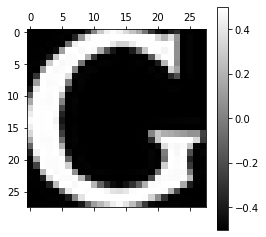

B


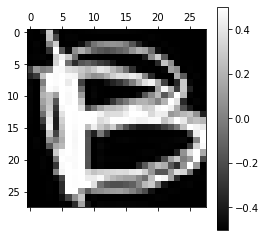

J


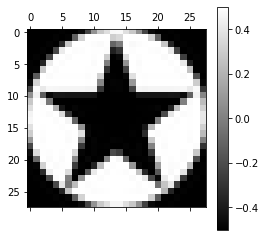

J


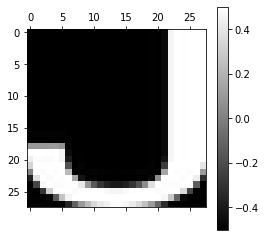

H


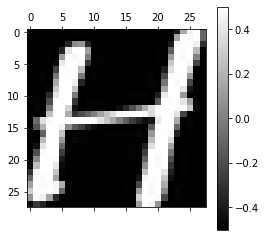

G


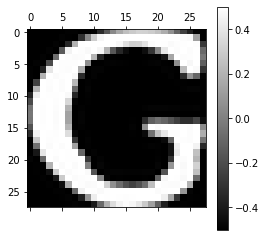

A


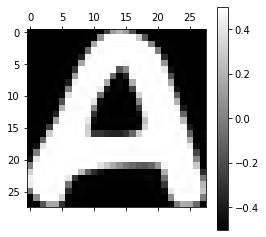

G


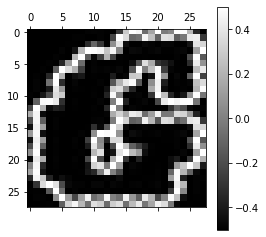

A


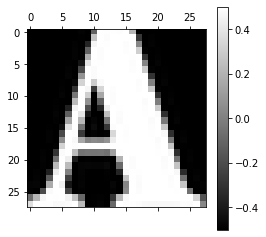

B


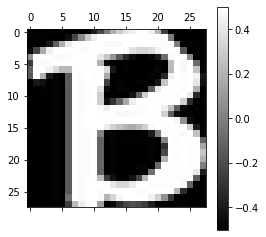

In [10]:
##########################################
# --- example solution for Problem 4 --- #
##########################################

# pick 10 random samples from training set
# display them and visually check chat the label is correct
# note that there are letters that are not recognizable
# thats part of the dataset

rand_sample_count = 10 #Subset

train_sample_count = train_dataset.shape[0] #Whole training dataset size
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

rand_indexes = np.random.randint(train_sample_count, size=rand_sample_count) #Generate random indexes to subset the training data
sample_data = train_dataset[rand_indexes, :, :] #Subsetting data
sample_labels = train_labels[rand_indexes] #Subsetting labels

# display image and label, and inspect that it looks like they match
for i in range(rand_sample_count):
    print(classes[sample_labels[i]])
    plt.matshow(sample_data[i], cmap=plt.cm.gray)
    plt.colorbar()
    plt.show()

---

Finally, let's save the data for later reuse:

In [11]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle') 

try:#Saving dataset as dict of np.arrays for labels & data
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [12]:
#https://www.geeksforgeeks.org/stat-command-in-linux-with-examples/
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800502


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [13]:
##########################################
# --- example solution for Problem 5 --- #
##########################################

# solution adapted from https://discussions.udacity.com/t/assignment-1-problem-5/45657/19
import time
import hashlib

t1 = time.time()

# calculate hash for each image
#Minimizer to avoid pairwise comparison of all pixels between images - https://cp-algorithms.com/string/string-hashing.html
# https://docs.python.org/2/library/hashlib.html
train_hashes = [hashlib.sha1(x).digest() for x in train_dataset]
valid_hashes = [hashlib.sha1(x).digest() for x in valid_dataset]
test_hashes  = [hashlib.sha1(x).digest() for x in test_dataset]

# find intersections
# http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.in1d.html - accepts 1-D nparray-like iterables (e.g. lists)
valid_in_train = np.in1d(valid_hashes, train_hashes)
valid_in_test = np.in1d(valid_hashes, test_hashes)
test_in_train  = np.in1d(test_hashes,  train_hashes)
test_in_valid  = np.in1d(test_hashes,  valid_hashes)

# remove duplicates ()
valid_keep = ~(valid_in_train | valid_in_test) #Return array of booleans for images that are not in training or test dataset (index defines label)
test_keep  = ~(test_in_train | test_in_valid) #Return array of booleans for images that are not in training or validation dataset (index defines label)

#Filtering duplicates
valid_dataset_clean = valid_dataset[valid_keep]
valid_labels_clean  = valid_labels [valid_keep]

test_dataset_clean = test_dataset[test_keep]
test_labels_clean  = test_labels [test_keep]

t2 = time.time()

print("Time: %0.2fs\n" % (t2 - t1))

print("Total Validation size %d" % valid_dataset.shape[0])
print("Validation size without duplicates %d\n" % valid_dataset_clean.shape[0])

print("Total Test size %d" % test_dataset.shape[0])
print("Test size without duplicates %d" % test_dataset_clean.shape[0])

Time: 1.39s

Total Validation size 10000
Validation size without duplicates 8881

Total Test size 10000
Test size without duplicates 8679


In [14]:
#Saving clean data
pickle_file = 'notMNIST.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset_clean,
        'valid_labels': valid_labels_clean,
        'test_dataset': test_dataset_clean,
        'test_labels': test_labels_clean,
        }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [15]:
##########################################
# --- example solution for Problem 6 --- #
##########################################

# reaload data from pickle
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (8881, 28, 28) (8881,)
Test set (8679, 28, 28) (8679,)


Deep Learning
=============

Assignment 2
------------

Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [16]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
#import tensorflow as tf

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from six.moves import cPickle as pickle
from six.moves import range

Instructions for updating:
non-resource variables are not supported in the long term


First reload the data we generated in `1_notmnist.ipynb`.

In [17]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (8881, 28, 28) (8881,)
Test set (8679, 28, 28) (8679,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [18]:
#Good review of one-hot encoding: https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32) #Flatten 2D image array to 1D image array for every label
  #Ref: https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  #Broadcasting - "extending" the dimension of labels to produce enough values to allow matrix operations (Slicing nparray with None or np.newaxis)
  ##https://numpy.org/doc/stable/user/basics.broadcasting.html
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32) #Generating array of booleans and converting them to np.float32 for each label for each image
  return dataset, labels

#Switching to one-hot encoding on all data subsets
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (8881, 784) (8881, 10)
Test set (8679, 784) (8679, 10)


We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [19]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :]) #Constants will not save history - not to be updated (https://www.tensorflow.org/api_docs/python/tf/constant)
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels])) #https://www.tensorflow.org/api_docs/python/tf/random/truncated_normal - list defines shape of the output matrix
    #total number of pixels per image * number of different labels = 256*256*10
  biases = tf.Variable(tf.zeros([num_labels])) #one bias for each label
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  # Useful links: https://machinelearningmastery.com/cross-entropy-for-machine-learning/
  # https://analyticsindiamag.com/a-beginners-guide-to-cross-entropy-in-machine-learning/#:~:text=The%20average%20number%20of%20bits,of%20actual%20and%20expected%20results.
  # https://datascience.stackexchange.com/questions/31041/what-does-logits-in-machine-learning-mean
  # https://www.analyticsvidhya.com/blog/2021/04/introduction-to-softmax-for-neural-network/

  logits = tf.matmul(tf_train_dataset, weights) + biases #Linear combination without activation function applied
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) #A python function 
  #Averages cross-entropy (loss) value for all data for given training iteration:
  #https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
  #https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  learning_rate = 0.5 #gradient descent "heap" size
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss) 
  #Function is used to compute gradient descend and store history to allow for backpropagation in order to minimize loss function: https://www.tensorflow.org/api_docs/python/tf/compat/v1/train/GradientDescentOptimizer#minimize
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits) #network output bordered from 0 to 1 to allow interpretation in terms of probability of the label corresponding to the image
  #https://www.tensorflow.org/api_docs/python/tf/nn/softmax
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases) #Network output on validation dataset
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases) #Network output on test dataset

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Let's run this computation and iterate:

In [20]:
num_steps = 801 #How many times the training dataset goes through the network (training epochs)

def accuracy(predictions, labels):
  #Accurate prediction: predicted label matches true label in test dataset
  #https://numpy.org/doc/stable/reference/generated/numpy.argmax.html#numpy.argmax:
  #1) find index of the maximum softmax value in prediction - most probable lable 
  #2) find index of the true lable (can be done with argmax because labels are one-hot encoded and anywhere except true label value is 0)
  #3) if indeces match - prediction is accurate - boolean test - if prediction is accurate, value is True, else - False
  #4) summing over array of booleans gives number of true in the array - number of accurately predicted samples
  #5) prediction.shape[0] gives the size of the prediction matrix (total number of predictions)
  #6) x100 allows to get % of accurately classified images
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps): #Perform network training form number of epochs
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    #Fetching data required to estimate accuracy after each training iteration
    if (step % 100 == 0): #Report loss at every 100th epoch
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%\n' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 21.026276
Training accuracy: 8.0%
Validation accuracy: 11.6%

Loss at step 100: 2.386050
Training accuracy: 71.4%
Validation accuracy: 69.5%

Loss at step 200: 1.887607
Training accuracy: 74.4%
Validation accuracy: 71.9%

Loss at step 300: 1.636586
Training accuracy: 75.8%
Validation accuracy: 72.8%

Loss at step 400: 1.471846
Training accuracy: 76.5%
Validation accuracy: 73.0%

Loss at step 500: 1.349764
Training accuracy: 77.0%
Validation accuracy: 73.3%

Loss at step 600: 1.253375
Training accuracy: 77.6%
Validation accuracy: 73.7%

Loss at step 700: 1.174422
Training accuracy: 78.2%
Validation accuracy: 73.8%

Loss at step 800: 1.108177
Training accuracy: 78.6%
Validation accuracy: 74.0%

Test accuracy: 81.3%


Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `session.run()`.

In [21]:
batch_size = 128 #Subsample data, as much less data is required to train sgd (10000 for gd)

graph = tf.Graph() #Init computation graph
with graph.as_default(): 

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size)) #Node used to subsample dataset (Tensor that stores subsample of batch size of image data)
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels)) #Node used to subsample labels (Tensor that stores subsample of batch size of image labels)
  # Loading validation & testing datasets
  tf_valid_dataset = tf.constant(valid_dataset) 
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels])) #Single hidden layer
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases 
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  learning_rate_sgd = 0.5
  optimizer = tf.train.GradientDescentOptimizer(learning_rate_sgd).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [22]:
num_steps = 3001 

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%\n" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 14.210457
Minibatch accuracy: 16.4%
Validation accuracy: 18.1%

Minibatch loss at step 500: 1.187820
Minibatch accuracy: 81.2%
Validation accuracy: 74.1%

Minibatch loss at step 1000: 1.695266
Minibatch accuracy: 74.2%
Validation accuracy: 74.7%

Minibatch loss at step 1500: 1.367056
Minibatch accuracy: 75.8%
Validation accuracy: 75.8%

Minibatch loss at step 2000: 1.089798
Minibatch accuracy: 78.1%
Validation accuracy: 76.4%

Minibatch loss at step 2500: 0.748621
Minibatch accuracy: 83.6%
Validation accuracy: 77.3%

Minibatch loss at step 3000: 1.107441
Minibatch accuracy: 73.4%
Validation accuracy: 77.0%

Test accuracy: 84.4%


---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

In [23]:
########################################
# --- example solution for Problem --- #
########################################

Load all the data into TensorFlow and build the computation graph:

In [24]:
###Defining hyperparameters
batch_size = 500 #Size of the subsample of images used in training during each iteration
dropout_rate = 0.125
hidden_layer_size_1 = 500 #Number of nodes in hidden layer
hidden_layer_size_2 = 500

###Useful links: 
"""
  https://www.deeplearning.ai/ai-notes/optimization/ - visulizing hyperparameter effects
  https://www.youtube.com/watch?v=1waHlpKiNyY&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc - more on hyperparameter tuning
  https://www.tutorialexample.com/initialize-tensorflow-weights-using-xavier-initialization-a-beginner-guide-tensorflow-tutorial/ - Xavier initialization of weights in tensorflow
  https://www.tensorflow.org/api_docs/python/tf/nn/dropout - dropout in tensorflow
"""

###Defining computational graph
graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Hidden layer 1 - variables.
  #Using Xavier initialization of weights
  weights_h_1 = tf.get_variable('w1', shape = [image_size * image_size, hidden_layer_size_1])  
  biases_h_1 = tf.Variable(tf.zeros([hidden_layer_size_1]))
    
  # Hidden layer 2 - variables.
  weights_h_2 = tf.get_variable('w2', shape = [hidden_layer_size_1, hidden_layer_size_2])
  biases_h_2 = tf.Variable(tf.zeros([hidden_layer_size_2]))

  # Output layer - variables.
  weights_out = tf.get_variable('w_o', shape = [hidden_layer_size_2, num_labels])
  biases_out = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  def compute_logits(inputs):
    hidden_layer_1 = tf.nn.dropout(tf.nn.relu(tf.matmul(inputs, weights_h_1) + biases_h_1), rate = dropout_rate, seed=1) #Compute output of the hidden layer 1 with dropout
    hidden_layer_2 = tf.nn.dropout(tf.nn.relu(tf.matmul(hidden_layer_1, weights_h_2) + biases_h_2), rate = dropout_rate, seed=1) #Compute output of the hidden layer 2 with dropout
    logits = tf.matmul(hidden_layer_2, weights_out) + biases_out #Compute output of the final layer (to be 'fed' to softmax)
    return logits 
  
  logits = compute_logits(tf_train_dataset)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) #Compute cross-entropy function and average accross output layer nodes
  
  # Optimizer.
  learning_rate = 0.7
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss) #Model to train
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(compute_logits(tf_valid_dataset))
  test_prediction = tf.nn.softmax(compute_logits(tf_test_dataset))

  

Run it:

Initialized
Minibatch loss at step 0: 2.382158
Minibatch accuracy: 10.4%
Validation accuracy: 35.4%

Minibatch loss at step 50: 0.607755
Minibatch accuracy: 80.4%
Validation accuracy: 81.6%

Minibatch loss at step 100: 0.546178
Minibatch accuracy: 84.6%
Validation accuracy: 83.2%

Minibatch loss at step 150: 0.516472
Minibatch accuracy: 83.8%
Validation accuracy: 84.4%

Minibatch loss at step 200: 0.500748
Minibatch accuracy: 85.4%
Validation accuracy: 84.8%

Minibatch loss at step 250: 0.496429
Minibatch accuracy: 88.2%
Validation accuracy: 84.7%

Minibatch loss at step 300: 0.507914
Minibatch accuracy: 83.8%
Validation accuracy: 85.6%

Minibatch loss at step 350: 0.408560
Minibatch accuracy: 88.4%
Validation accuracy: 86.0%

Minibatch loss at step 400: 0.431171
Minibatch accuracy: 85.6%
Validation accuracy: 86.1%

Minibatch loss at step 450: 0.420436
Minibatch accuracy: 87.6%
Validation accuracy: 86.6%

Minibatch loss at step 500: 0.398457
Minibatch accuracy: 87.6%
Validation accurac

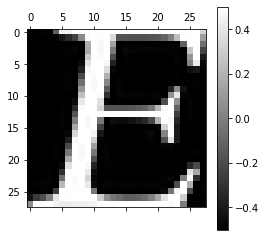

#2.
Predicted label: A
True lable: A


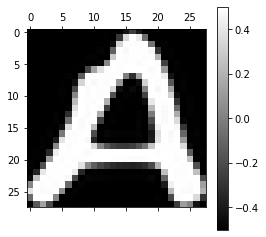

#3.
Predicted label: E
True lable: E


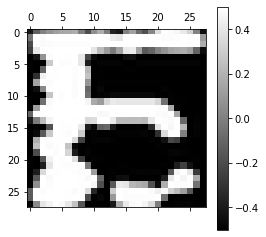

#4.
Predicted label: H
True lable: H


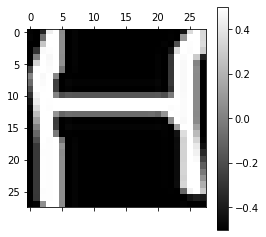

#5.
Predicted label: J
True lable: J


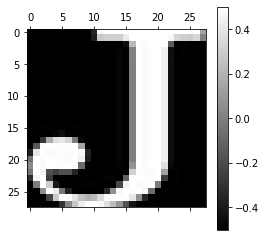

#6.
Predicted label: J
True lable: J


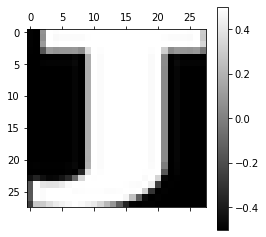

#7.
Predicted label: G
True lable: G


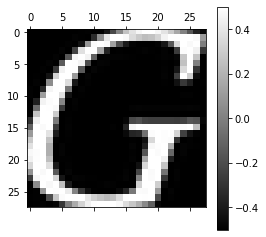

#8.
Predicted label: E
True lable: E


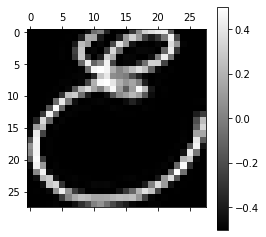

#9.
Predicted label: I
True lable: I


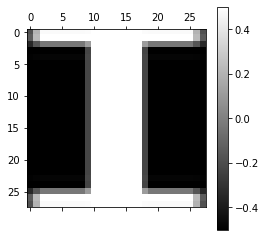

#10.
Predicted label: G
True lable: G


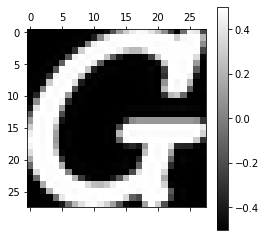

#11.
Predicted label: G
True lable: G


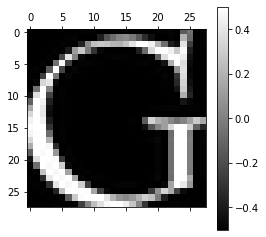

#12.
Predicted label: E
True lable: E


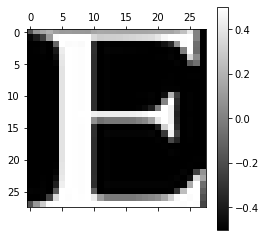

#13.
Predicted label: J
True lable: J


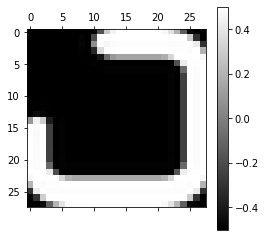

#14.
Predicted label: C
True lable: C


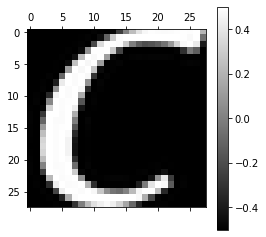

#15.
Predicted label: B
True lable: B


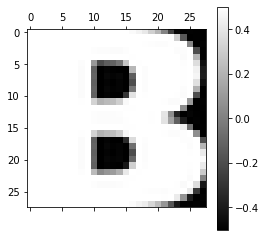

#16.
Predicted label: D
True lable: D


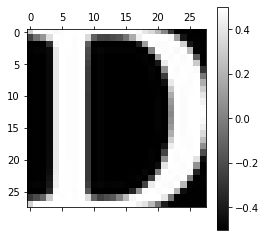

#17.
Predicted label: I
True lable: I


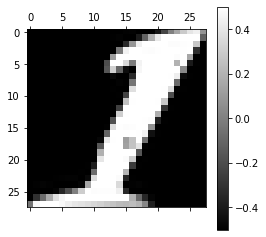

#18.
Predicted label: G
True lable: B


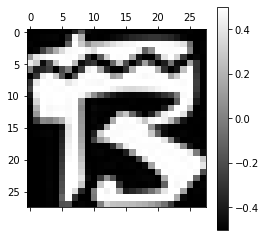

#19.
Predicted label: I
True lable: I


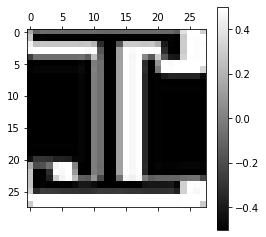

#20.
Predicted label: I
True lable: B


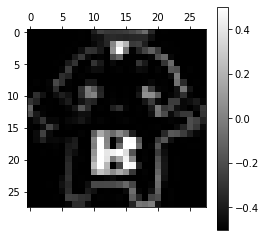

#21.
Predicted label: C
True lable: C


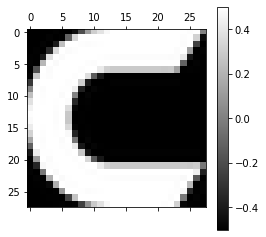

#22.
Predicted label: E
True lable: E


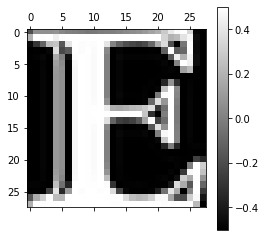

#23.
Predicted label: C
True lable: C


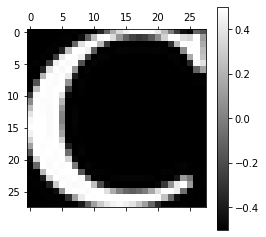

#24.
Predicted label: G
True lable: G


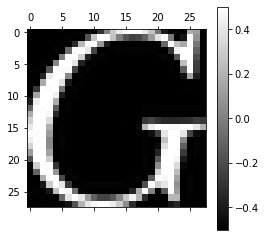

#25.
Predicted label: G
True lable: G


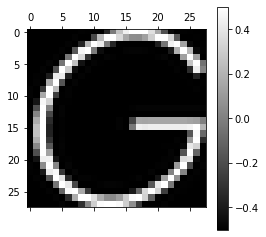

#26.
Predicted label: G
True lable: G


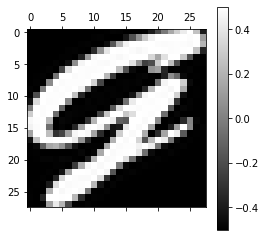

#27.
Predicted label: A
True lable: A


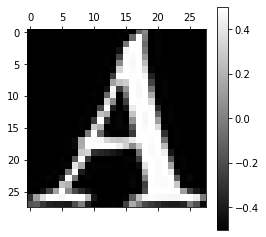

#28.
Predicted label: H
True lable: H


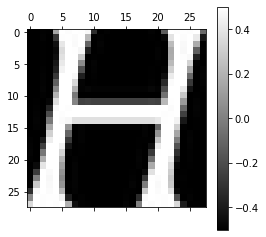

#29.
Predicted label: I
True lable: I


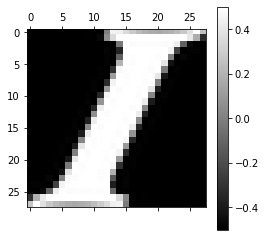

#30.
Predicted label: B
True lable: B


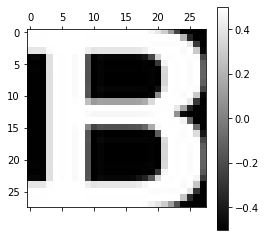

In [29]:
num_steps = 10000
acc_valid = 90
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs. (Current offset gives a linear increase in offset size over iterations)
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      validation_accuracy = accuracy(valid_prediction.eval(), valid_labels)
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%\n" % validation_accuracy)
      if validation_accuracy >= acc_valid:
        break
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

  ###Verifying the result

  #Generate random indexes to subset the training data
  rand_indexes = np.random.randint(test_dataset.shape[0], size=30) 

  #Reload plottable data from file
  with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    p_test_dataset = save['test_dataset']
    del save  # hint to help gc free up memory

  #Show images, true labels & predicted labels
  print('\nRESULT VERIFICATION\n')
  for j,i in enumerate(rand_indexes):
    print(f"#{j+1}.\nPredicted label: {classes[np.argmax(test_prediction.eval()[i])]}\nTrue lable: {classes[np.argmax(test_labels[i])]}")
    image_data = p_test_dataset[i,:,:]
    plt.matshow(image_data, cmap=plt.cm.gray)
    plt.colorbar()
    plt.show()
